In [1]:
import os, sys, wave, struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import cmath
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy import linalg as la
import randproc as rp
import pyaudio
import IPython.display as ipd

## 1.1
### 1

To generate an AR signal the formula implemented was: $X_t = X_{t-1}\phi_t + \epsilon$. Where $\epsilon$ is a centered random gaussian variable with variance $\sigma^2$ given by the function.

In [2]:
def ar(coef, sigma, n, order):
    # Coef: coefficient vector of size n
    # sigma: white noise variance
    # n: size of array
    # order: autoregressive order
    
    ar = np.zeros(n)
    ar[0] = np.random.normal(0, sigma)
    for k in range(order, n):
        ar[k] = ar[k-1]*coef + np.random.normal(0, sigma)
    return ar

## 1.2
### 2

Firstly I implemented the periodogram manually with the functions periodogram_manual and FiP by manually computing the dft. It worked perfectly but isn't as computationally efficient as scipy's own. So, I chose to use np.fft.fft in the periodogram function. 

When one chooses the periodogram, the function takes the entire vector and simply applies the dft and normalizes.

If the bartlett method is chosen the original array is reshaped by window size and the dft is applied on each segment, and then it averages out by frequency each of the sub-arrays obtained. There is a loss in resolution because the output's resolution is the same as the length of the window used.

For the welch method, an overlap of 50% was implemented, thus resulting in twice as many windows as previously but the same resolution. 

In [3]:
def periodogram(x, method='normal', window_length=1):
    # x: input
    # method: can be normal, welch, or bartlett
    # window_length: for bartlett and welch is the desired window length
    pxx = np.zeros(len(x))
    if method == 'welch':
        n_windows = int(2*len(x)/window_length)
        aux = np.array([])
        aux = np.append(aux, x[:int(window_length/2)])
        aux = np.append(aux, x[-int(window_length/2):])
        for i in range(n_windows-1):
            aux = np.append(aux, x[int(i*window_length/2) : int(i*window_length/2+window_length)])
        aux = aux.reshape((n_windows, window_length))
        pxx = aux.copy()
        
        # Calculates each window's periodogram
        for i in range(n_windows):
            pxx[i, :] = abs(np.fft.fft(aux[i, :]))**2/(window_length/2)
        
        pxx = pxx.mean(0)
        freq = np.array(range(window_length))/window_length
    
    elif method == 'bartlett':
        n_windows = int(len(x)/window_length) # Determines number of windows
        x = x.reshape((n_windows, window_length)) # multiplies by rectangular window and displaces the window
        freq = np.array(range(window_length))/window_length # Calculates frequencies for plot
        pxx = np.zeros(np.shape(x))
        
        # Calculates each window's periodogram
        for i in range(n_windows):
            pxx[i, :] = abs(np.fft.fft(x[i, :]))**2/(window_length/2)
            
        pxx = pxx.mean(0) # takes the average of each window's periodogram for each frequency
        
    else: 
        freq = np.array(range(len(x)))/len(x) # Calculates frequencies for plot
        pxx = abs(np.fft.fft(x))**2/(len(x)/2) # does the fft
    return freq, pxx

def fiP (x, omega):
    # Auxiliary function to calculate each φ for the manual periodogram
    aux = 0
    for i in range(len(x)):
        aux += x[i]*cmath.exp(-1j*omega*i)
    aux = abs(aux)**2/(len(x)/2)
    return aux

def periodogram_manual(x):
    # Manually calculates periodogram
    pxx = np.zeros(len(x))
    freq = 2*np.pi*np.array(range(len(x)))/len(x)
    for i in range(len(x)):
        pxx[i] = fiP(x, freq[i])
    return pxx

Initializing an AR random process

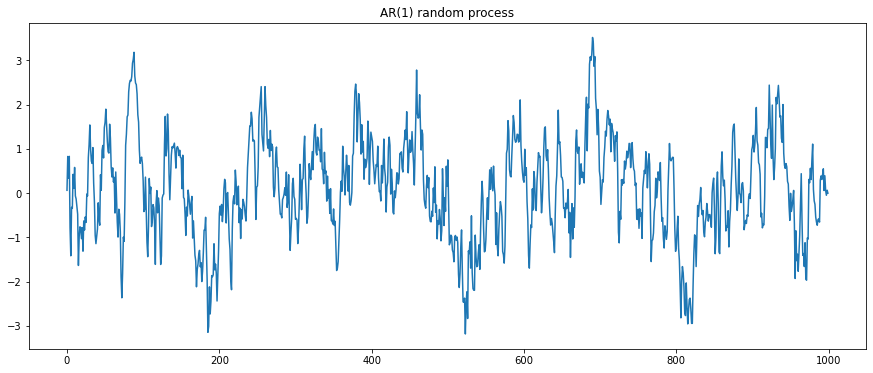

In [4]:
#coef = np.random.normal(0, 0.3, 1000)
coef = 0.9
y = ar(coef, 0.5, 1000, 1)
plt.figure(figsize=(15, 6))
plt.title('AR(1) random process')
plt.plot(y)
plt.show()

In [5]:
fper, pper = periodogram(y)
p_manual = periodogram_manual(y)

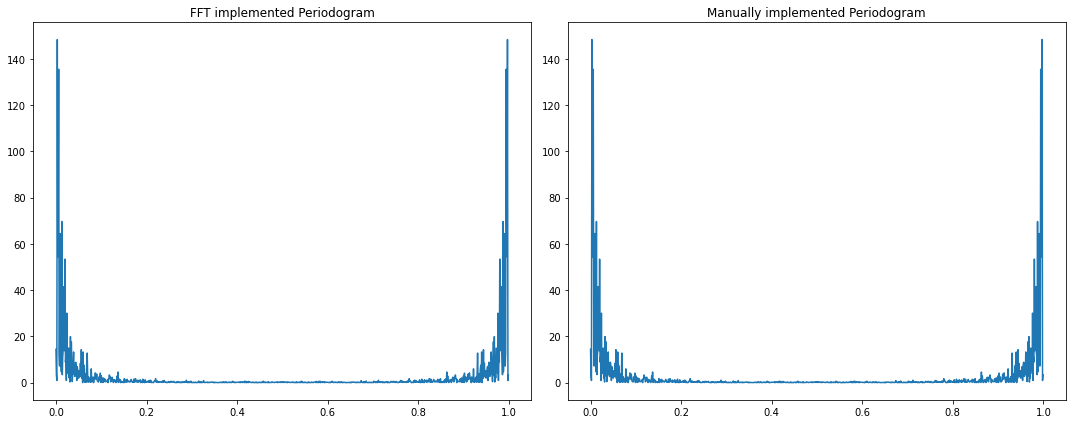

In [6]:
plt.subplots(1, 2, figsize = (15, 6))

plt.subplot(121)
plt.title('FFT implemented Periodogram')
plt.plot(fper, pper)

plt.subplot(122)
plt.title('Manually implemented Periodogram')
plt.plot(fper, p_manual)

plt.tight_layout()
plt.show()

Since the results were identical, from now on,  I will use the FFT because it is optimized

In [7]:
fbart, pbart = periodogram(y, method='bartlett', window_length=100)
fwel, pwel = periodogram(y, method='welch', window_length=100)

### 3
To calculate the power spectrum density of the AR(1) function the formula used was: $S(f) = \frac{\sigma^2}{1+\phi^2 - 2\phi cos(2\pi f)}$. The curves tend to overlap nicely with the periodograms for the given parameters.

In [8]:
def AR_PSD(sigma, phi, freq):
    return sigma/(1+phi**2-2*phi*np.cos(2*np.pi*freq))

In [9]:
bartpsd = AR_PSD(0.5, coef, fbart)
perpsd = AR_PSD(0.5, coef, fper)

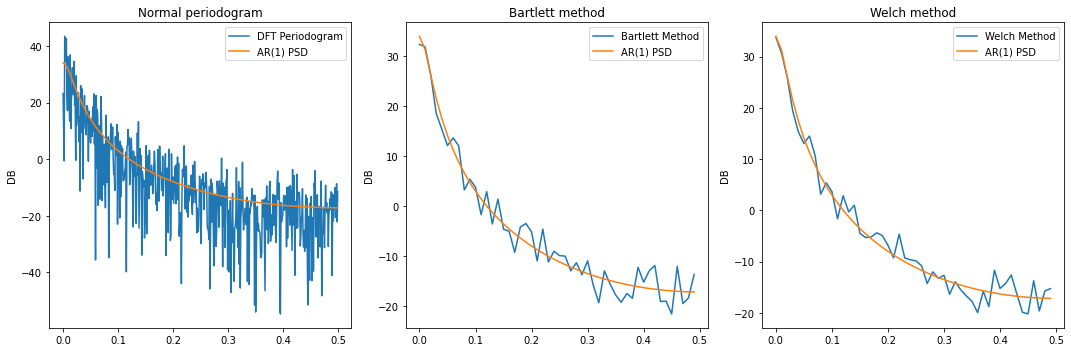

In [10]:
plt.subplots(1, 3, figsize=(15,5))

plt.subplot(131)
plt.title('Normal periodogram')
plt.plot(fper[:int(len(fper)/2)], 20*np.log10(pper)[:int(len(pper)/2)], label='DFT Periodogram')
plt.plot(fper[:int(len(fper)/2)], 20*np.log10(perpsd)[:int(len(perpsd)/2)], color='C1', label='AR(1) PSD')
plt.ylabel('DB')
plt.legend()

plt.subplot(132)
plt.title('Bartlett method')
plt.plot(fbart[:int(len(fbart)/2)], 20*np.log10(pbart)[:int(len(pbart)/2)], label='Bartlett Method')
plt.plot(fbart[:int(len(fbart)/2)], 20*np.log10(bartpsd)[:int(len(bartpsd)/2)], color='C1', label='AR(1) PSD')
plt.ylabel('DB')
plt.legend()

plt.subplot(133)
plt.title('Welch method')
plt.plot(fwel[:int(len(fwel)/2)], 20*np.log10(pwel)[:int(len(pwel)/2)], label='Welch Method')
plt.plot(fbart[:int(len(fbart)/2)], 20*np.log10(bartpsd)[:int(len(bartpsd)/2)], color='C1', label='AR(1) PSD')
plt.ylabel('DB')
plt.legend()

plt.tight_layout()
plt.show()

### 4
We can observe that both the bartlett and the welch method have considerably less variance, which they earn at the cost of a lower resolution. However, the bias seems relatively unchanged when compared to a normal periodogram.

In [11]:
pper.mean()

2.5272091882399117

In [12]:
variance = np.array([np.var(pper), np.var(pbart), np.var(pwel)])
label=['normal', 'bartlett', 'welch']
mse = np.array([])
mse = np.append(mse, mean_squared_error(pper, perpsd))
mse = np.append(mse, mean_squared_error(pbart, bartpsd))
mse = np.append(mse, mean_squared_error(pwel, bartpsd))
bias = np.sqrt(abs(mse-variance))

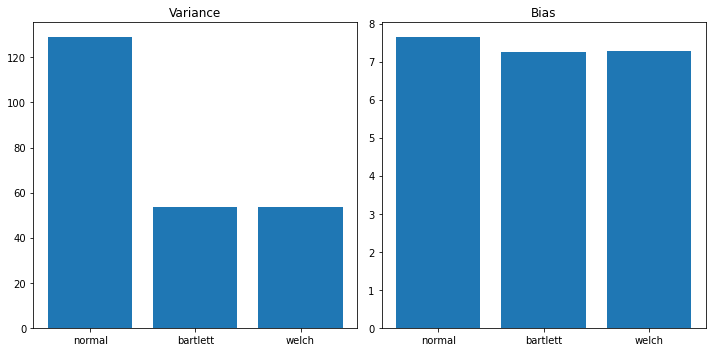

In [13]:
plt.subplots(1, 2, figsize=(10,5))

plt.subplot(121)
plt.bar(label, variance)
plt.title('Variance')

plt.subplot(122)
plt.bar(label, bias)
plt.title('Bias')

plt.tight_layout()
plt.show()

## 1.3
### 5
The recommendation given to us by our professor, Ac2poly, doesn't work, it always raises the "singular matrix" flag.

In [14]:
#ac2poly(y)

So I did a linear regression using $X_t$ as y and $X_{t-1}$ as the features and for the error variance I calculated the MSE.

In [15]:
y_reg = y[:-1]
x_reg = y[1:].reshape(-1, 1)
reg = LinearRegression().fit(x_reg, y_reg)
pred = reg.predict(x_reg)

In [16]:
estimated_coef = reg.coef_[0]
sigma2 = mean_squared_error(y_reg, pred)
print(f'The regression obtained {estimated_coef:.4f} as the coefficient and {sigma2:.4f} as the error variance')

The regression obtained 0.8951 as the coefficient and 0.2501 as the error variance


I also applied the code from TSIA202a and tried it as well.

In [17]:
# CODE FROM TSIA202a
def TS1_Linear_Prediction(y, p=1, display=True):
    #p=1
    gamma =  rp.acovb(y)
    Gamma_hat = la.toeplitz(gamma[0:p+1])

    v1 = np.zeros(p+1)
    v1[0]=1
    c = np.dot(la.inv(Gamma_hat),v1)

    sigma2Est = 1/c[0]
    estimated_coeff= c * sigma2Est
    if display == True:
        print(f'The regression obtained {-estimated_coeff[1]:.4f} as the coefficient and {sigma2Est:.4f} as the error variance')
    return sigma2Est, estimated_coeff

In [18]:
coef = np.array([1, -coef])
sigma2Est, estimated_coeff = TS1_Linear_Prediction(y)

The regression obtained 0.8951 as the coefficient and 0.2498 as the error variance


Both performed practically identically, to me it made intuitive sense that the MSE of the linear regression's prediction would work as an estimator for the noise's variance, but I didn't expect it to perform identically to the one coded in TS1. They were able to predict the coefficient used pretty well, but both were far off with the error variance.

To superimpose the spectra I also re-used some code from TSIA202a.

In [19]:
# CODE FROM TSIA202a
def superimposed_spectra(estimated_coeff, y, coef=[None], plot=True):
    
    nPoints = np.int(np.exp2( np.ceil(np.log2(y.size))))
    nu = np.linspace(-0.5, 0.5 - 1/nPoints, nPoints)
    omega = 2*np.pi*nu
    w2, H2 = sig.freqz([1], estimated_coeff, omega)
    _, aux=periodogram(y)
    freq=np.linspace(-0.5, 0.5, len(y))
    aux2=aux[int(len(aux)/2):].copy()
    aux2=np.concatenate([aux2, aux[0:int(len(aux)/2)]])
    
    if plot==True:
        plt.figure(figsize=(15, 6))
        plt.plot(w2/(2*np.pi),20*np.log10(abs(H2)), label='Amplitude Frequency Response (FR) of the AR filter')
        if coef[0]!=None:
            w1, H1 = sig.freqz([1], coef, omega)
            plt.plot(w1/(2*np.pi),20*np.log10(abs(H1)), label='Estimated Amplitude FR')
        plt.plot(freq, 20*np.log10(aux2), label='Periodogram')
        plt.ylabel('DB')
        plt.xlabel('Frequency')
        plt.legend()
        plt.show()
    else:
        return (w2/(2*np.pi))[int(len(w2)/2):], 20*np.log10(abs(H2))[int(len(H2)/2):]

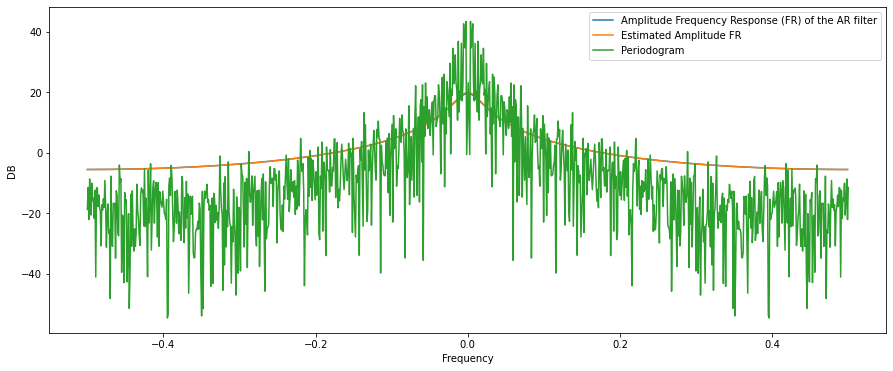

In [20]:
superimposed_spectra(estimated_coeff, y, coef=coef)

### 7

To open the .wav, I chose to re-use code from TSIA201 because of familiarity.

In [21]:
# CODE FROM TSIA201

def load_sound(file):
    return wave.open(file, 'rb')

def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
      
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

In [22]:
# CODE FROM TSIA201
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

In [23]:
# CODE FROM TSIA201
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [24]:
# CODE FROM TSIA201
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)
x = x/32768

In [25]:
# CODE FROM TSIA201
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

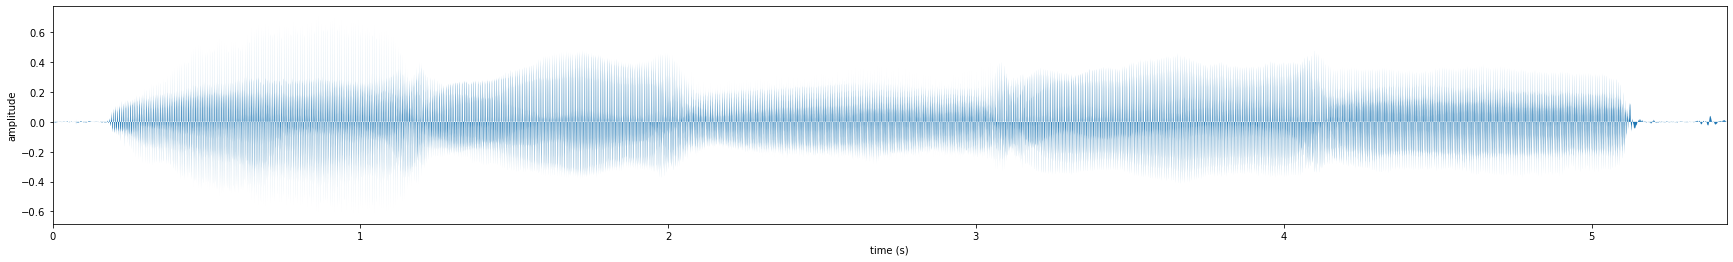

In [26]:
plot_sound(x, times)

In [27]:
ipd.Audio(x, rate=11025)

Time to trim the audio to isolate only one vowel

Visually it looks like "a" goes from 0.1 to around 1.2. So if we only isolate the times between 0.2 and 1 seconds we can isolate a piece of "a".

In [28]:
np.argmax(times>0.2)

2206

In [29]:
np.argmin(times<1)

11025

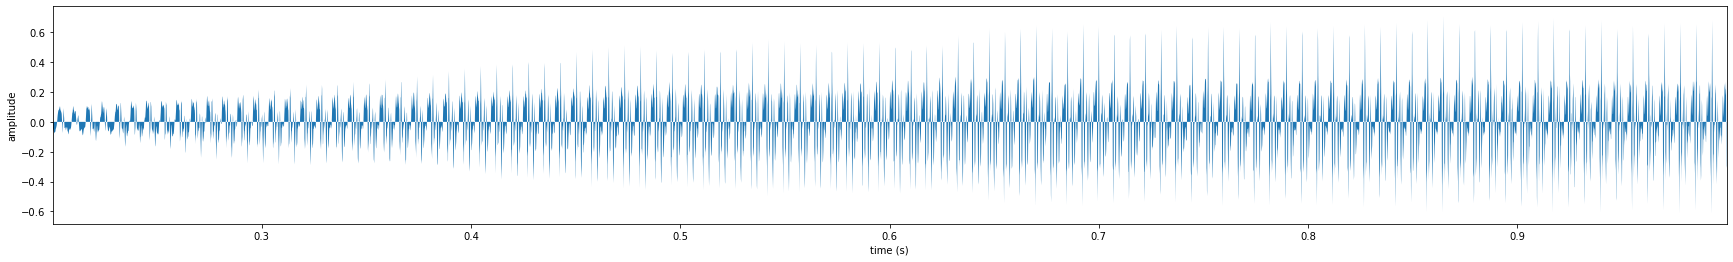

In [30]:
vowel_a = x[2206:11025]
time_a = times[2206:11025]
plot_sound(vowel_a, time_a)

In [31]:
ipd.Audio(vowel_a, rate=11025)

It worked nicely

In [32]:
a_sigma, a_estimate = TS1_Linear_Prediction(vowel_a)

The regression obtained 0.8572 as the coefficient and 0.0092 as the error variance


In [33]:
len(vowel_a)

8819

The graphs are similar, but not very similar. I believe that an AR(1) model isn't the best choice for this signal.

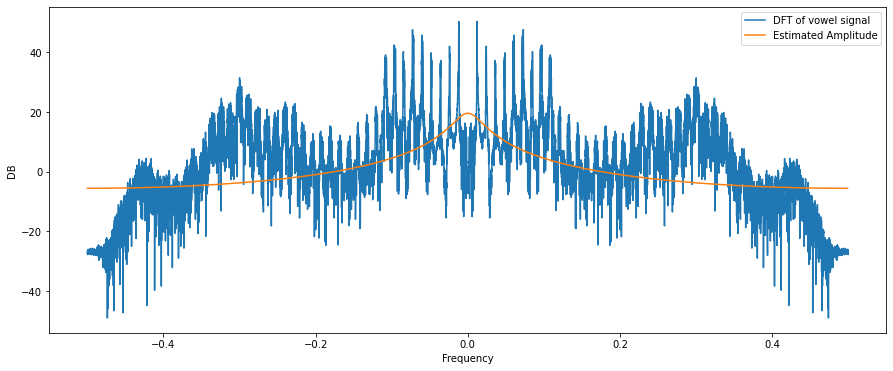

In [34]:
# CODE FROM TSIA202a
plt.figure(figsize=(15, 6))
nPoints = np.int(np.exp2( np.ceil(np.log2(y.size))))
nu = np.linspace(-0.5, 0.5 - 1/nPoints, nPoints)
omega = 2*np.pi*nu
w2, H2 = sig.freqz([1], estimated_coeff, omega)
H2 = abs(H2)
_, per_a = periodogram(vowel_a)
freq_a = np.linspace(-0.5, 0.5, len(per_a))
per_a= abs(np.fft.fft(vowel_a))
aux2=per_a[int(len(per_a)/2):].copy()
aux2=np.concatenate([aux2, per_a[0:int(len(per_a)/2)]])
plt.plot(freq_a, 20*np.log10(aux2), label='DFT of vowel signal')
plt.plot(w2/(2*np.pi),20*np.log10(H2), label='Estimated Amplitude')
plt.ylabel('DB')
plt.xlabel('Frequency')
plt.legend()
plt.show()

## 2.1

In [35]:
def sinusoid_synthesis (length, n_sin, freq, amp, phase, sigma2):
    # freq, amp and phase must be of size n_sin
    sinusoid = np.zeros(length)
    aux = np.linspace(0, length, length, endpoint=False)
    
    for i in range(n_sin):
        sinusoid += amp[i]*np.sin(2*np.pi*freq[i]*aux/length+phase[i])
    return sinusoid + np.random.normal(0, sigma2, length)
    

## 2.2
### 2

In [36]:
sinusoid = sinusoid_synthesis(500, 2, [50, 200], [1, 1], [0, 0], 2)

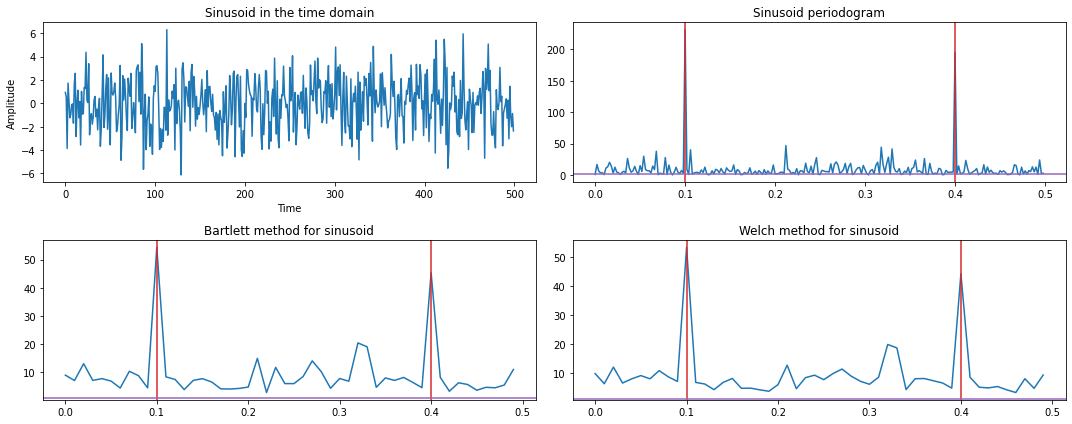

In [37]:
plt.subplots(2, 2, figsize=(15, 6))

plt.subplot(221)
plt.title('Sinusoid in the time domain')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(sinusoid)

plt.subplot(222)
plt.title('Sinusoid periodogram')
sin_per_freq, sin_per = periodogram(sinusoid)
plt.plot(sin_per_freq[:int(len(sinusoid)/2)], sin_per[:int(len(sinusoid)/2)])
plt.axvline(50/500, color='C3')
plt.axvline(200/500, color='C3')
plt.axhline(1, color='C4')

plt.subplot(223)
plt.title('Bartlett method for sinusoid')
sin_bar_freq, sin_bar = periodogram(sinusoid, method='bartlett', window_length=100)
plt.plot(sin_bar_freq[:int(len(sin_bar)/2)], sin_bar[:int(len(sin_bar)/2)])
plt.axvline(50/500, color='C3')
plt.axvline(200/500, color='C3')
plt.axhline(1, color='C4')

plt.subplot(224)
plt.title('Welch method for sinusoid')
sin_wel_freq, sin_wel = periodogram(sinusoid, method='welch', window_length=100)
plt.plot(sin_wel_freq[:int(len(sin_wel)/2)], sin_wel[:int(len(sin_wel)/2)])
plt.axvline(50/500, color='C3')
plt.axvline(200/500, color='C3')
plt.axhline(1, color='C4')

plt.tight_layout()
plt.show()

### 3

I wasn't sure what was expected so I just varied the $|ν_1-ν_2|$ to see the resolution and then varied the noise. When varying the frequency distance it can be seen that because of Welch and Bartlett's methods' lower resolution they had a difficult time differentiating the frequency peaks at difference of 0.05 for a window size that is 10 times smaller than the actual signal.

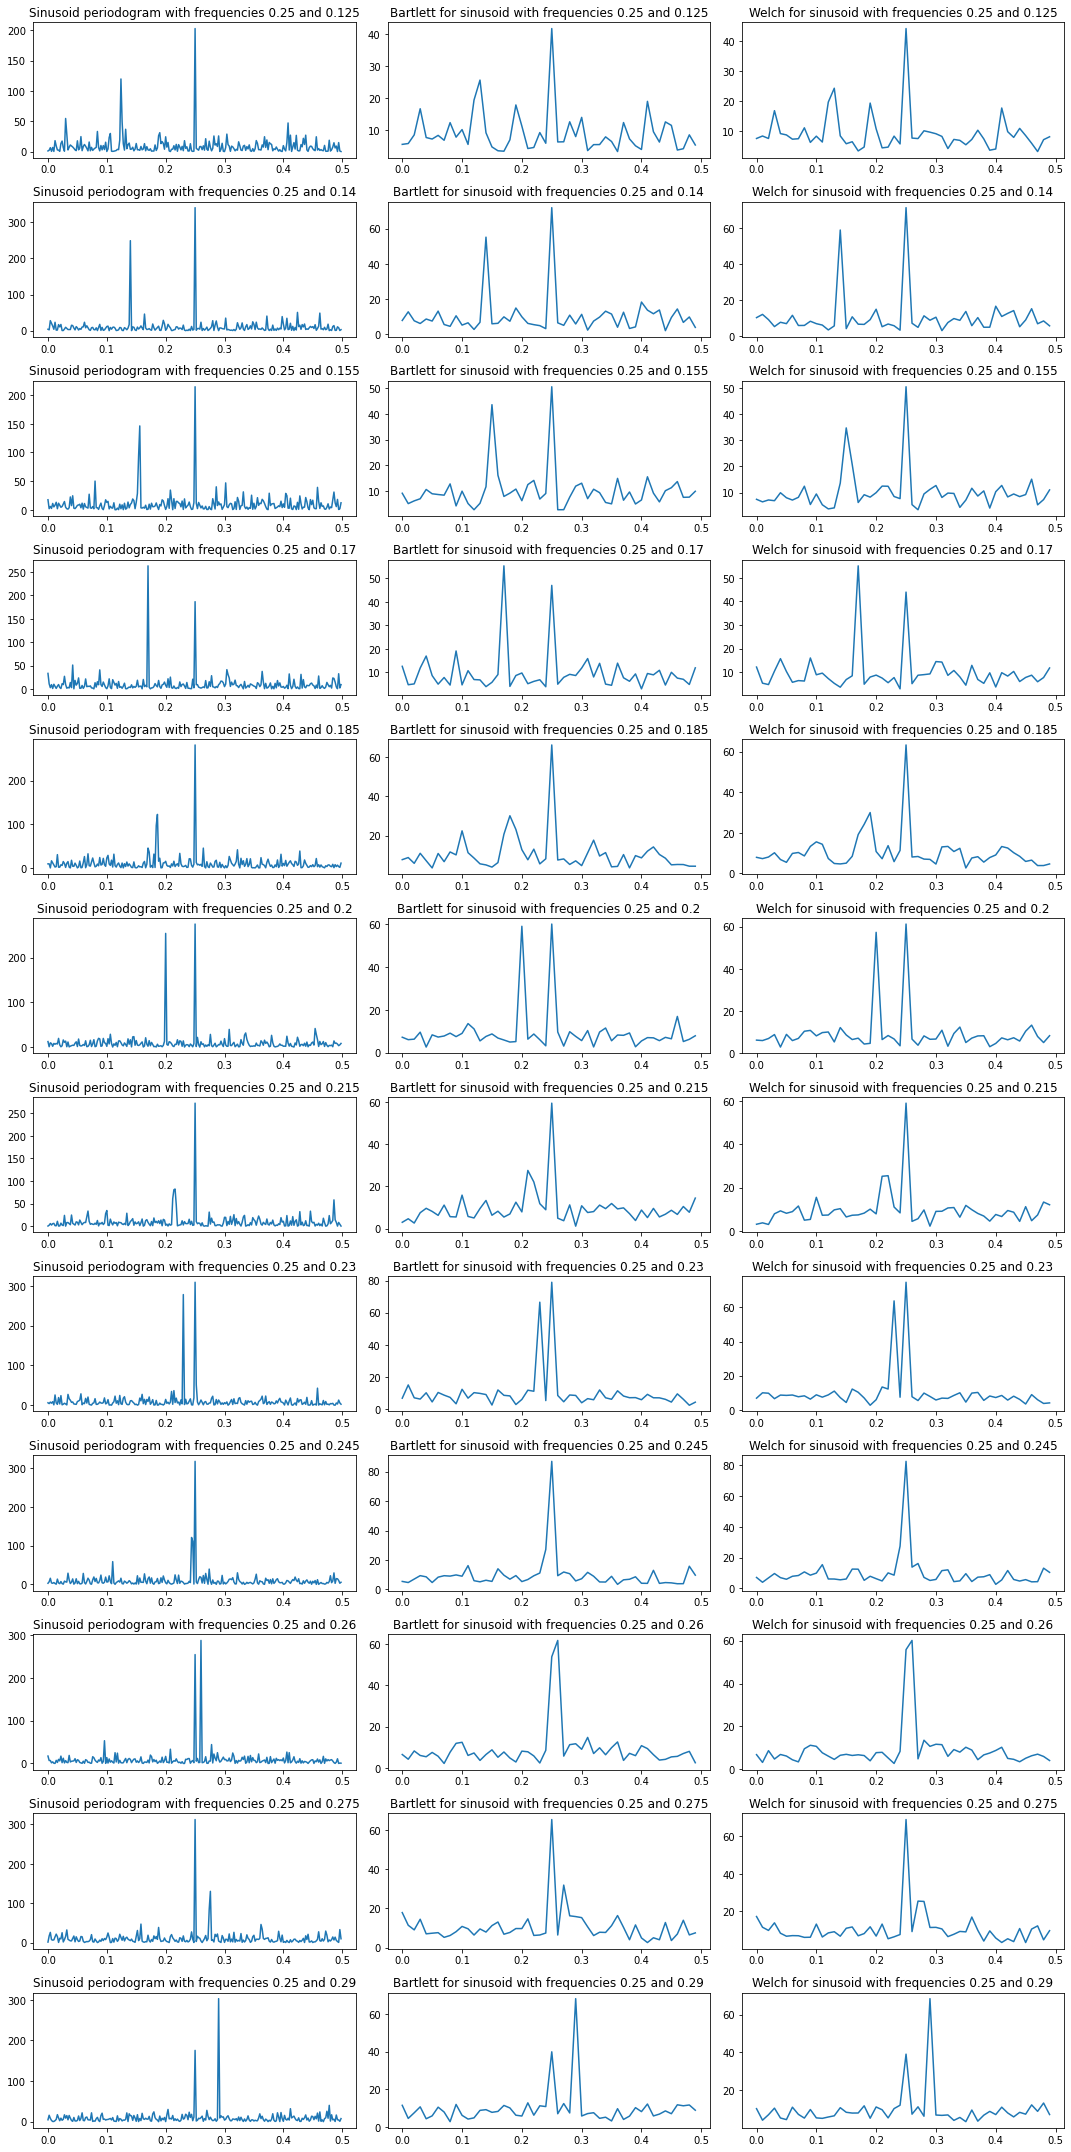

In [38]:
plt.subplots(12, 3, figsize=(15, 30))
for i in range(12):
    sinusoid = sinusoid_synthesis(500, 2, [125, 62.5 + i*7.5], [1, 1], [0, 0], 2)
    
    plt.subplot(12, 3, i*3+1)
    plt.title(f'Sinusoid periodogram with frequencies 0.25 and {(62.5 + i*7.5)/500}')
    sin_per_freq, sin_per = periodogram(sinusoid)
    plt.plot(sin_per_freq[:int(len(sinusoid)/2)], sin_per[:int(len(sinusoid)/2)])
    
    plt.subplot(12, 3, i*3+2)
    plt.title(f'Bartlett for sinusoid with frequencies 0.25 and {(62.5 + i*7.5)/500}')
    sin_bar_freq, sin_bar = periodogram(sinusoid, method='bartlett', window_length=100)
    plt.plot(sin_bar_freq[:int(len(sin_bar)/2)], sin_bar[:int(len(sin_bar)/2)])
    
    plt.subplot(12, 3, i*3+3)
    plt.title(f'Welch for sinusoid with frequencies 0.25 and {(62.5 + i*7.5)/500}')
    sin_wel_freq, sin_wel = periodogram(sinusoid, method='welch', window_length=100)
    plt.plot(sin_wel_freq[:int(len(sin_wel)/2)], sin_wel[:int(len(sin_wel)/2)])
    
plt.tight_layout()
plt.show()


Defining SNR as: $log_{10}\left(\frac{\sum A_k}{\sigma^2}\right)$ where $A_k$ is each sinusoid's individual amplitude. Thus we can see that the resolution is terrible when SNR is smaller than zero and improves after it becomes positive. This happens because when the SNR is negative, the noise's amplitude is larger than the sinusoid, so it was too large to distinguish. But when it decreases the resolution improves.

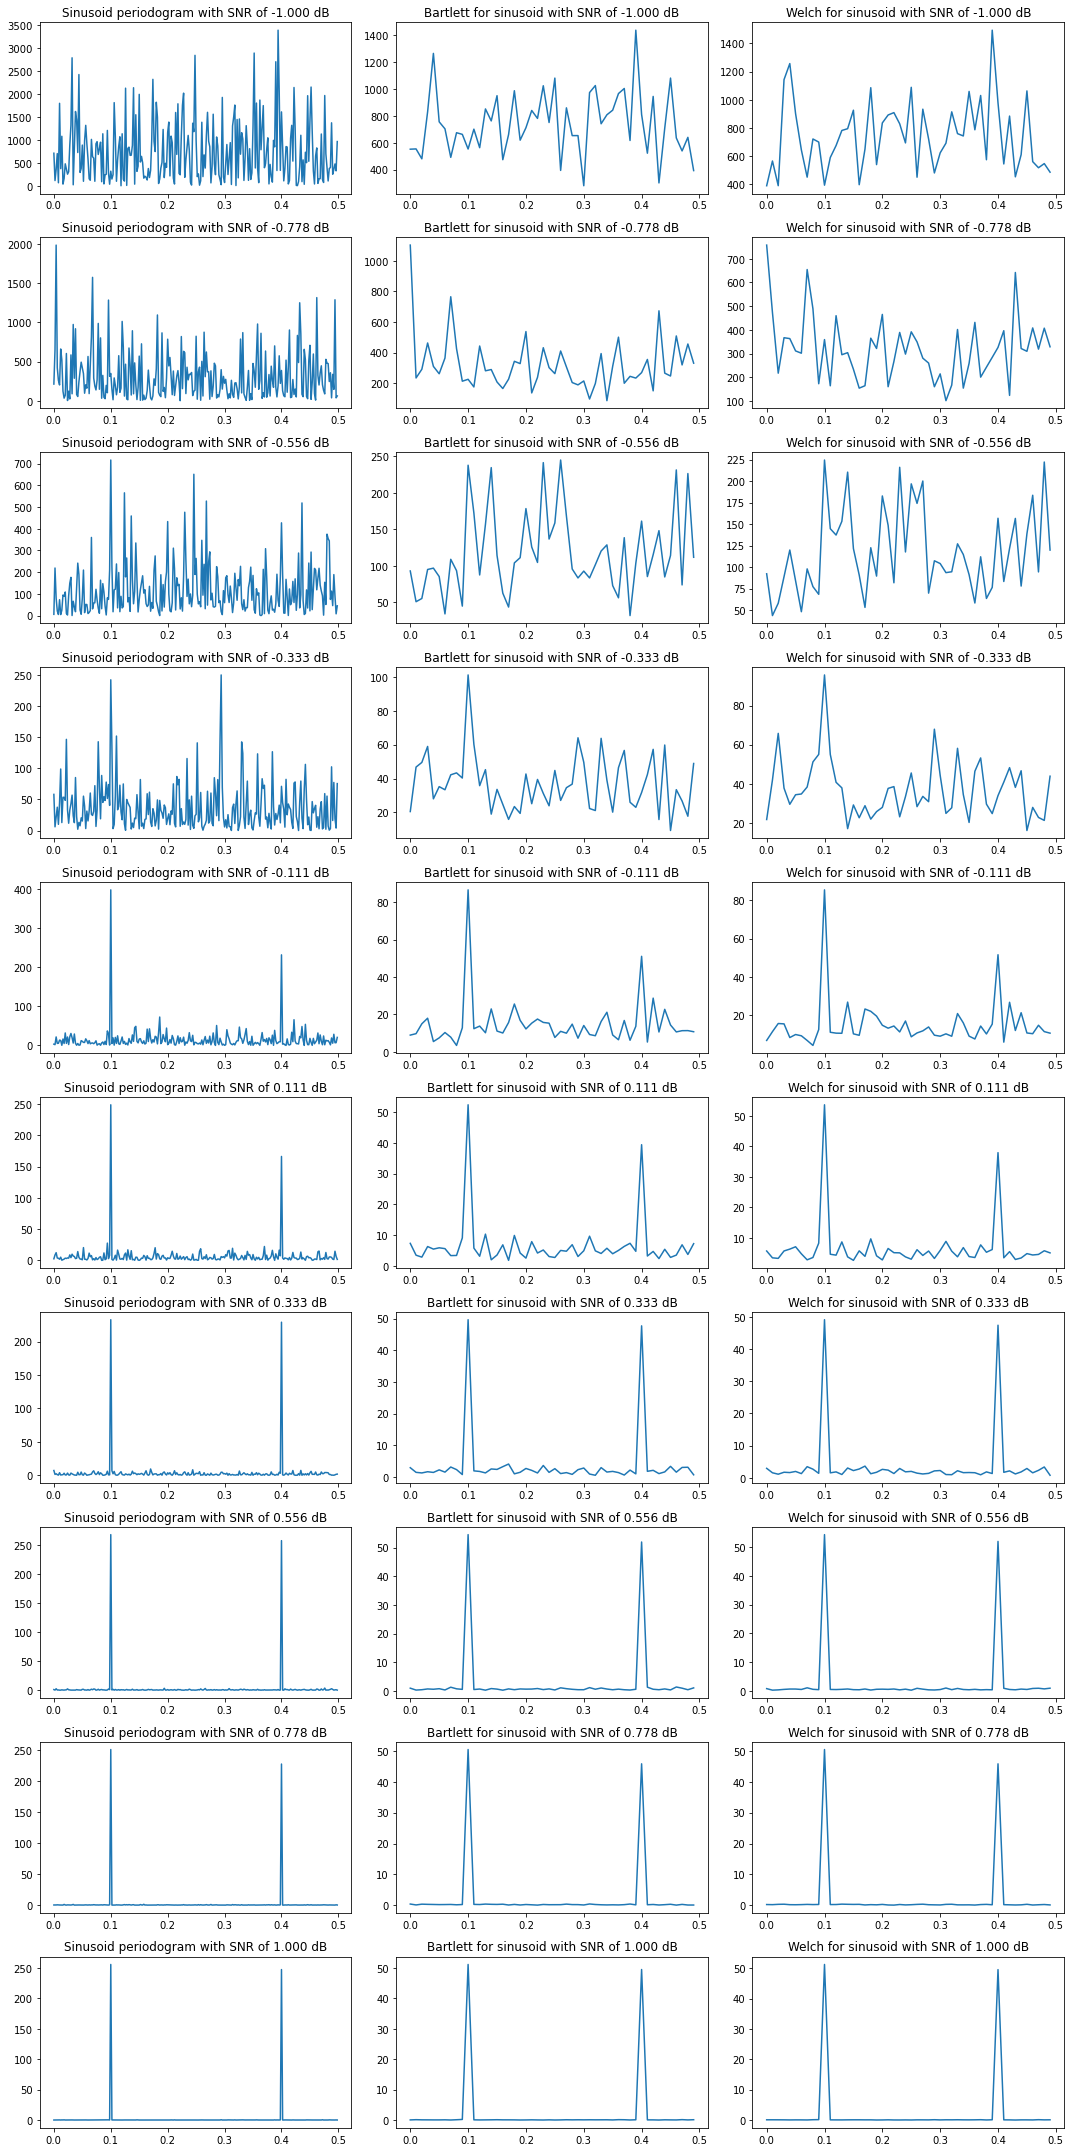

In [39]:
plt.subplots(10, 3, figsize=(15, 30))
aux = np.linspace(-1, 1, 10)
noise = 2/(10**aux)
for i in range(10):
    sinusoid = sinusoid_synthesis(500, 2, [50, 200], [1, 1], [0, 0], noise[i])
    
    plt.subplot(10, 3, i*3+1)
    plt.title(f'Sinusoid periodogram with SNR of {np.log10(2/noise[i]):.3f} dB')
    sin_per_freq, sin_per = periodogram(sinusoid)
    plt.plot(sin_per_freq[:int(len(sinusoid)/2)], sin_per[:int(len(sinusoid)/2)])
    
    plt.subplot(10, 3, i*3+2)
    plt.title(f'Bartlett for sinusoid with SNR of {np.log10(2/noise[i]):.3f} dB')
    sin_bar_freq, sin_bar = periodogram(sinusoid, method='bartlett', window_length=100)
    plt.plot(sin_bar_freq[:int(len(sin_bar)/2)], sin_bar[:int(len(sin_bar)/2)])
    
    plt.subplot(10, 3, i*3+3)
    plt.title(f'Welch for sinusoid with SNR of {np.log10(2/noise[i]):.3f} dB')
    sin_wel_freq, sin_wel = periodogram(sinusoid, method='welch', window_length=100)
    plt.plot(sin_wel_freq[:int(len(sin_wel)/2)], sin_wel[:int(len(sin_wel)/2)])
    
plt.tight_layout()
plt.show()


## 2.3
### 4

Using the TSIA202a code the following result was obtained. By using an AR(4) we were able to correctly estimate the frequencies used by sinusoid generator, but the periodogram isn't similar at all.

In [40]:
sinusoid = sinusoid_synthesis(500, 2, [50, 200], [1, 1], [0, 0], 1)

In [41]:
sig2_sin, est_sin_coef = TS1_Linear_Prediction(sinusoid, p=4, display=False)
print(f'The coefficients obtained for the sinusoid were: {est_sin_coef}')

The coefficients obtained for the sinusoid were: [ 1.         -0.00919787 -0.27775582  0.01929965  0.46148231]


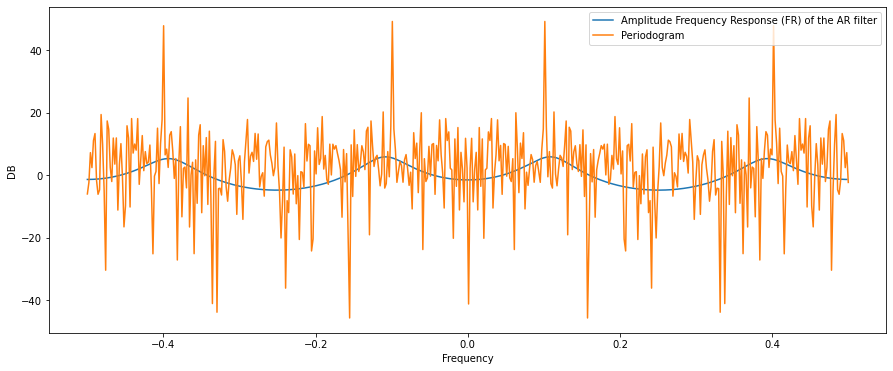

In [42]:
superimposed_spectra(est_sin_coef, sinusoid)

### 5
Predicting the sinusoids as AR(p) is not very good resolution-wise because when the frequencies are too close together the peaks become clumped and indistinguishable from each other. 

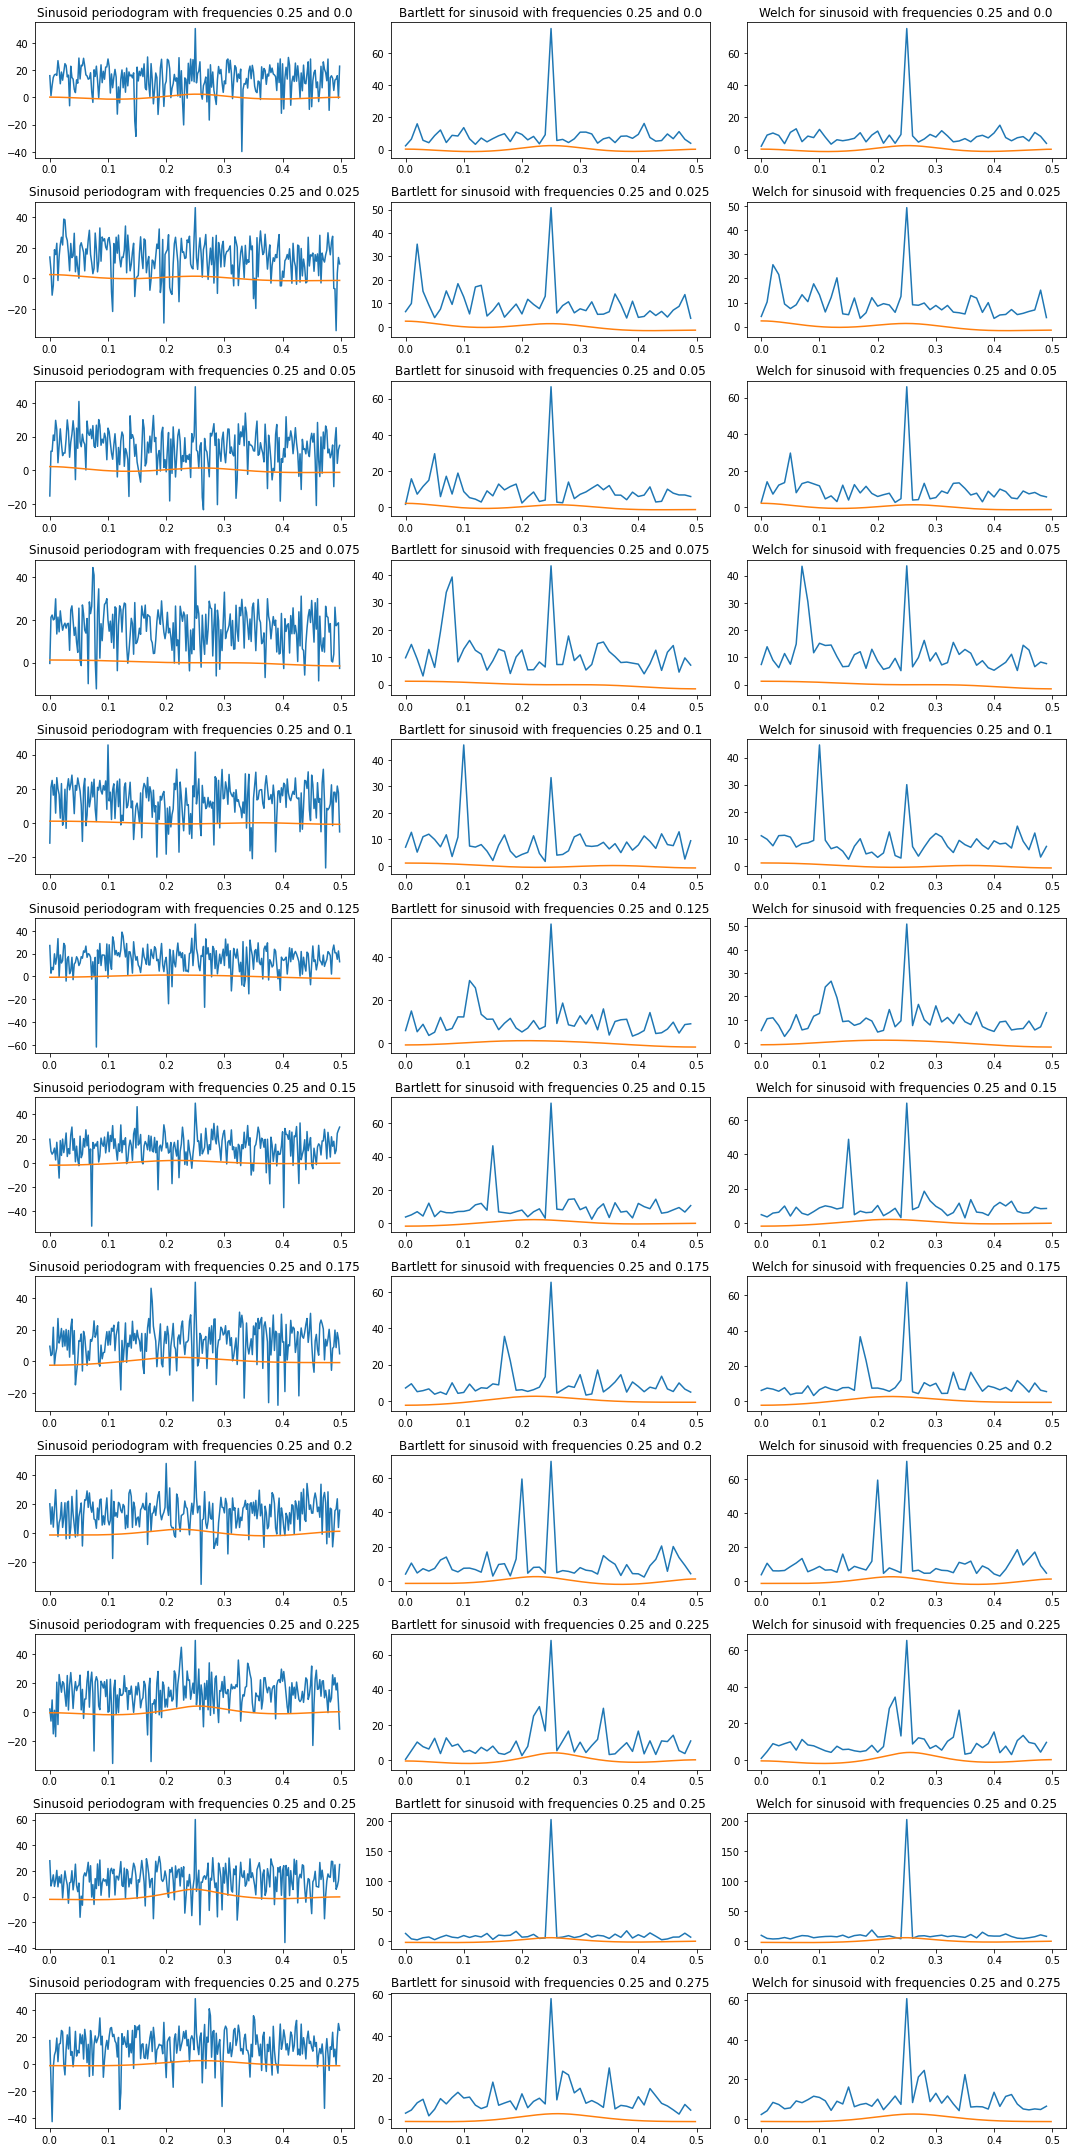

In [43]:
plt.subplots(12, 3, figsize=(15, 30))
for i in range(12):
    sinusoid = sinusoid_synthesis(500, 2, [125, i*12.5], [1, 1], [0, 0], 2)
    sig2_sin, est_sin_coef = TS1_Linear_Prediction(sinusoid, p=4, display=False)
    sig_pred_freq, sig_pred = superimposed_spectra(est_sin_coef, sinusoid, plot=False)
    
    plt.subplot(12, 3, i*3+1)
    plt.title(f'Sinusoid periodogram with frequencies 0.25 and {i*12.5/500}')
    sin_per_freq, sin_per = periodogram(sinusoid)
    plt.plot(sin_per_freq[:int(len(sinusoid)/2)], 20*np.log10(sin_per[:int(len(sinusoid)/2)]))
    plt.plot(sig_pred_freq, sig_pred)
    
    plt.subplot(12, 3, i*3+2)
    plt.title(f'Bartlett for sinusoid with frequencies 0.25 and {i*12.5/500}')
    sin_bar_freq, sin_bar = periodogram(sinusoid, method='bartlett', window_length=100)
    plt.plot(sin_bar_freq[:int(len(sin_bar)/2)], sin_bar[:int(len(sin_bar)/2)])
    plt.plot(sig_pred_freq, sig_pred)
    
    plt.subplot(12, 3, i*3+3)
    plt.title(f'Welch for sinusoid with frequencies 0.25 and {i*12.5/500}')
    sin_wel_freq, sin_wel = periodogram(sinusoid, method='welch', window_length=100)
    plt.plot(sin_wel_freq[:int(len(sin_wel)/2)], sin_wel[:int(len(sin_wel)/2)])
    plt.plot(sig_pred_freq, sig_pred)
    
plt.tight_layout()
plt.show()



As for the robustness to error variance when using an AR(4) model, it displays a similar performance to the original, having difficulty with a negative SNR but being able to identify the frequencies once it becomes positive.

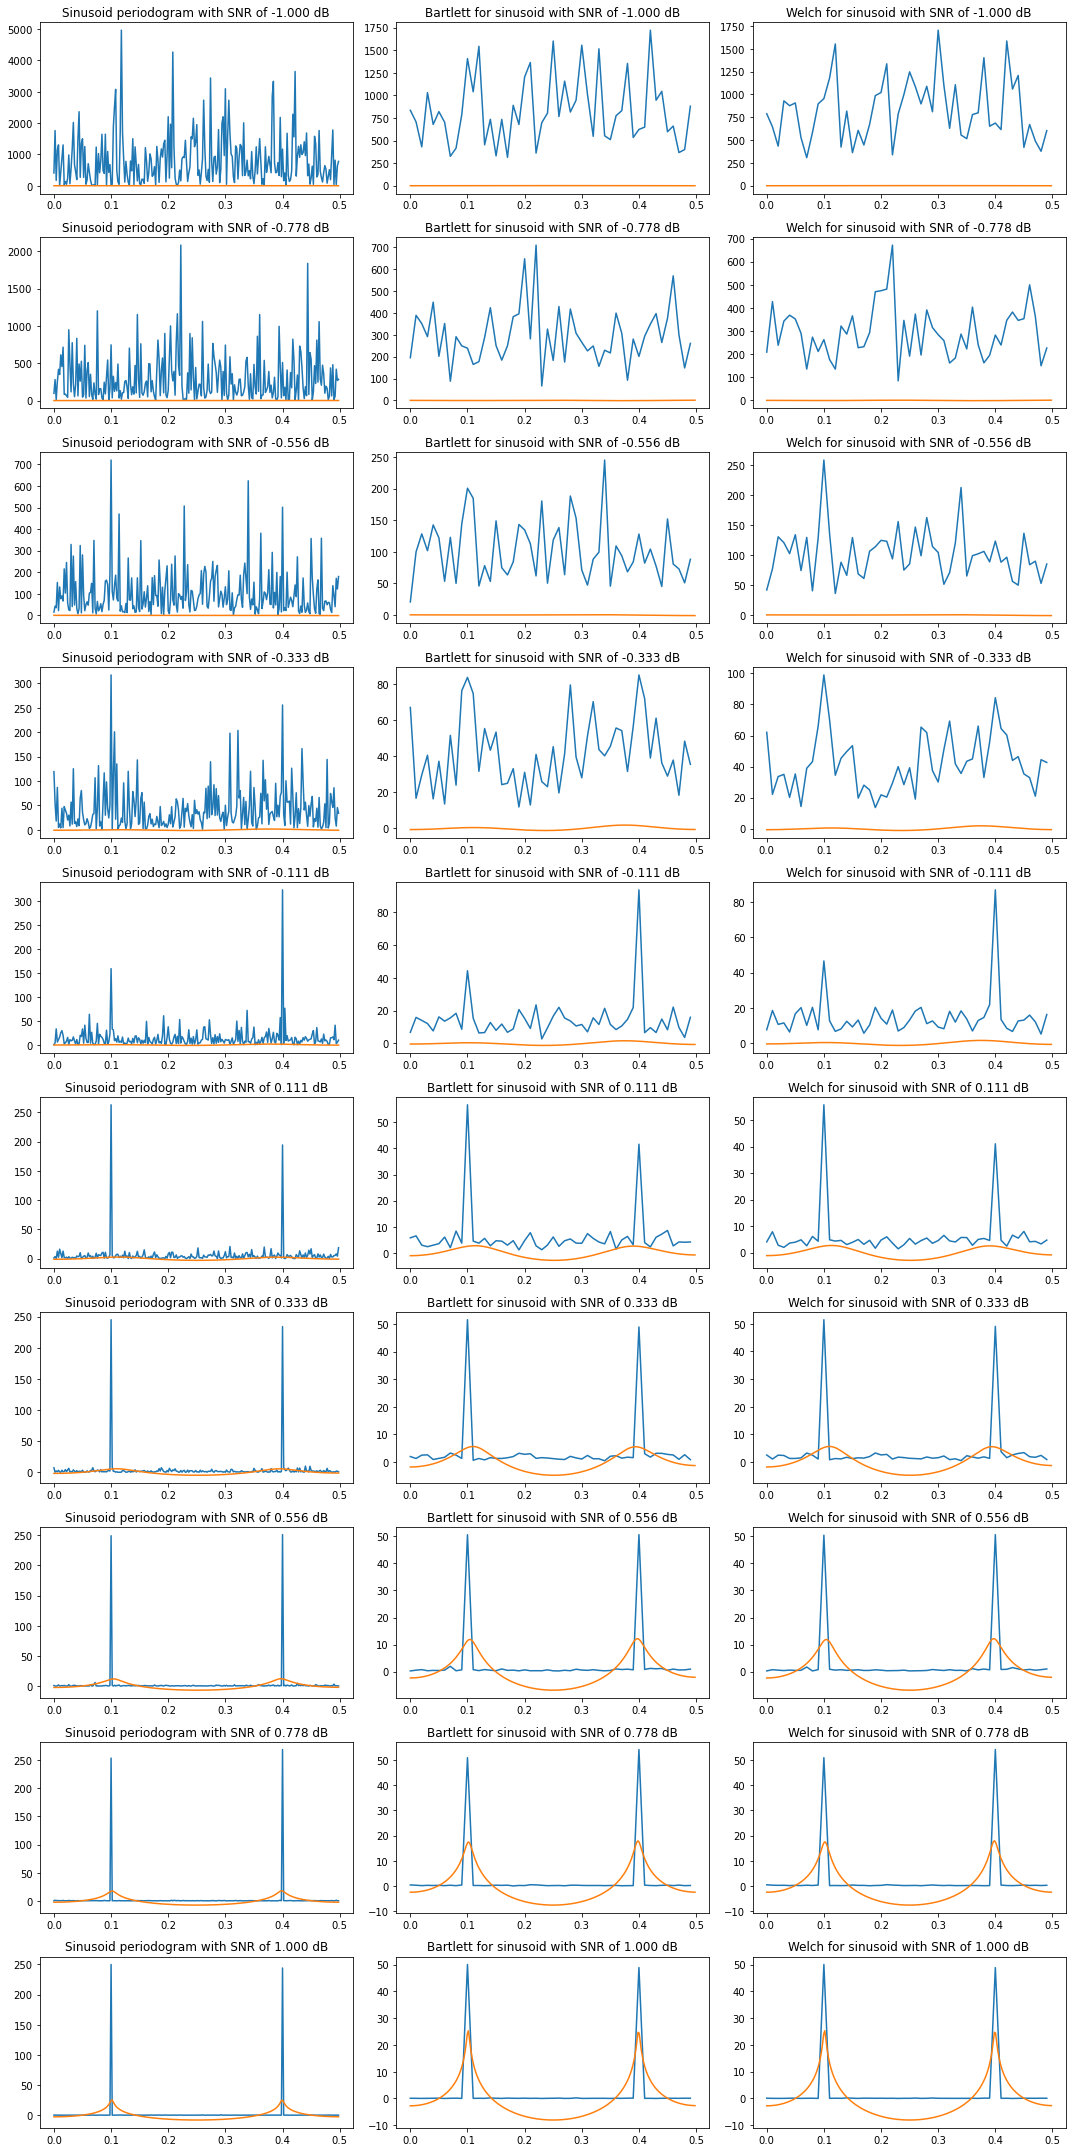

In [44]:
plt.subplots(10, 3, figsize=(15, 30))
aux = np.linspace(-1, 1, 10)
noise = 2/(10**aux)
for i in range(10):
    sinusoid = sinusoid_synthesis(500, 2, [50, 200], [1, 1], [0, 0], noise[i])
    sig2_sin, est_sin_coef = TS1_Linear_Prediction(sinusoid, p=4, display=False)
    sig_pred_freq, sig_pred = superimposed_spectra(est_sin_coef, sinusoid, plot=False)
    
    plt.subplot(10, 3, i*3+1)
    plt.title(f'Sinusoid periodogram with SNR of {np.log10(2/noise[i]):.3f} dB')
    sin_per_freq, sin_per = periodogram(sinusoid)
    plt.plot(sin_per_freq[:int(len(sinusoid)/2)], sin_per[:int(len(sinusoid)/2)])
    plt.plot(sig_pred_freq, sig_pred)
    
    plt.subplot(10, 3, i*3+2)
    plt.title(f'Bartlett for sinusoid with SNR of {np.log10(2/noise[i]):.3f} dB')
    sin_bar_freq, sin_bar = periodogram(sinusoid, method='bartlett', window_length=100)
    plt.plot(sin_bar_freq[:int(len(sin_bar)/2)], sin_bar[:int(len(sin_bar)/2)])
    plt.plot(sig_pred_freq, sig_pred)
    
    plt.subplot(10, 3, i*3+3)
    plt.title(f'Welch for sinusoid with SNR of {np.log10(2/noise[i]):.3f} dB')
    sin_wel_freq, sin_wel = periodogram(sinusoid, method='welch', window_length=100)
    plt.plot(sin_wel_freq[:int(len(sin_wel)/2)], sin_wel[:int(len(sin_wel)/2)])
    plt.plot(sig_pred_freq, sig_pred)
    
plt.tight_layout()
plt.show()

## 2.4
### 6
The capon method was done using the following formula: 
$$\phi(\omega) = \frac{m+1}{a(\omega)^*R^{-1}a(\omega))}$$

Where:
$$a(\omega) = [1, e^{-i \omega},\ldots, e^{-i \omega m}]^T \textrm{, with shape } (m+1, 1)$$
$$a(\omega)^* = [1, \overline{e^{-i \omega}},\ldots, \overline{e^{-i \omega m}}]\textrm{, with shape } (1, m+1)$$
$$R = \frac{1}{N-m}\sum_{m}^{N}[y(t), \ldots, y(t-m)]^T[y^*(t), \ldots, y^*(t-m)]\textrm{, with shape } (m+1, m+1)$$

In [45]:
def a_capon(freq, m):
    a = np.arange(0, m+1)
    a = np.exp(-2*a*np.pi*freq*1j)
    return np.conjugate(a).reshape(1, m+1), a.reshape(m+1, 1)

def R_inverse(y, m):
    R = np.zeros((m+1)**2).reshape(m+1, m+1)
    for i in range(m, len(y)):
        a = y[i-m:i+1].copy().reshape(m+1, 1)
        a_conj = np.conjugate(a).reshape(1, m+1)
        R += a@a_conj
    R = R/(len(y)-m)
    return np.linalg.inv(R)
   
def capon(y, m, freq):
    cap = np.array([])
    R = R_inverse(y, m)
    for i in freq:
        a_conj, a = a_capon(i,  m)
        cap = np.concatenate([cap, ((m+1)/(a_conj@R@a))[0]])
    return abs(np.array(cap))

### 7

The Capon estimator wasn't that troubled by frequencies that were near one another, despite the shrinking difference in frequency, it was able to differentiate pretty well. Its performance was superior to the Bartlett and Welch methods. 

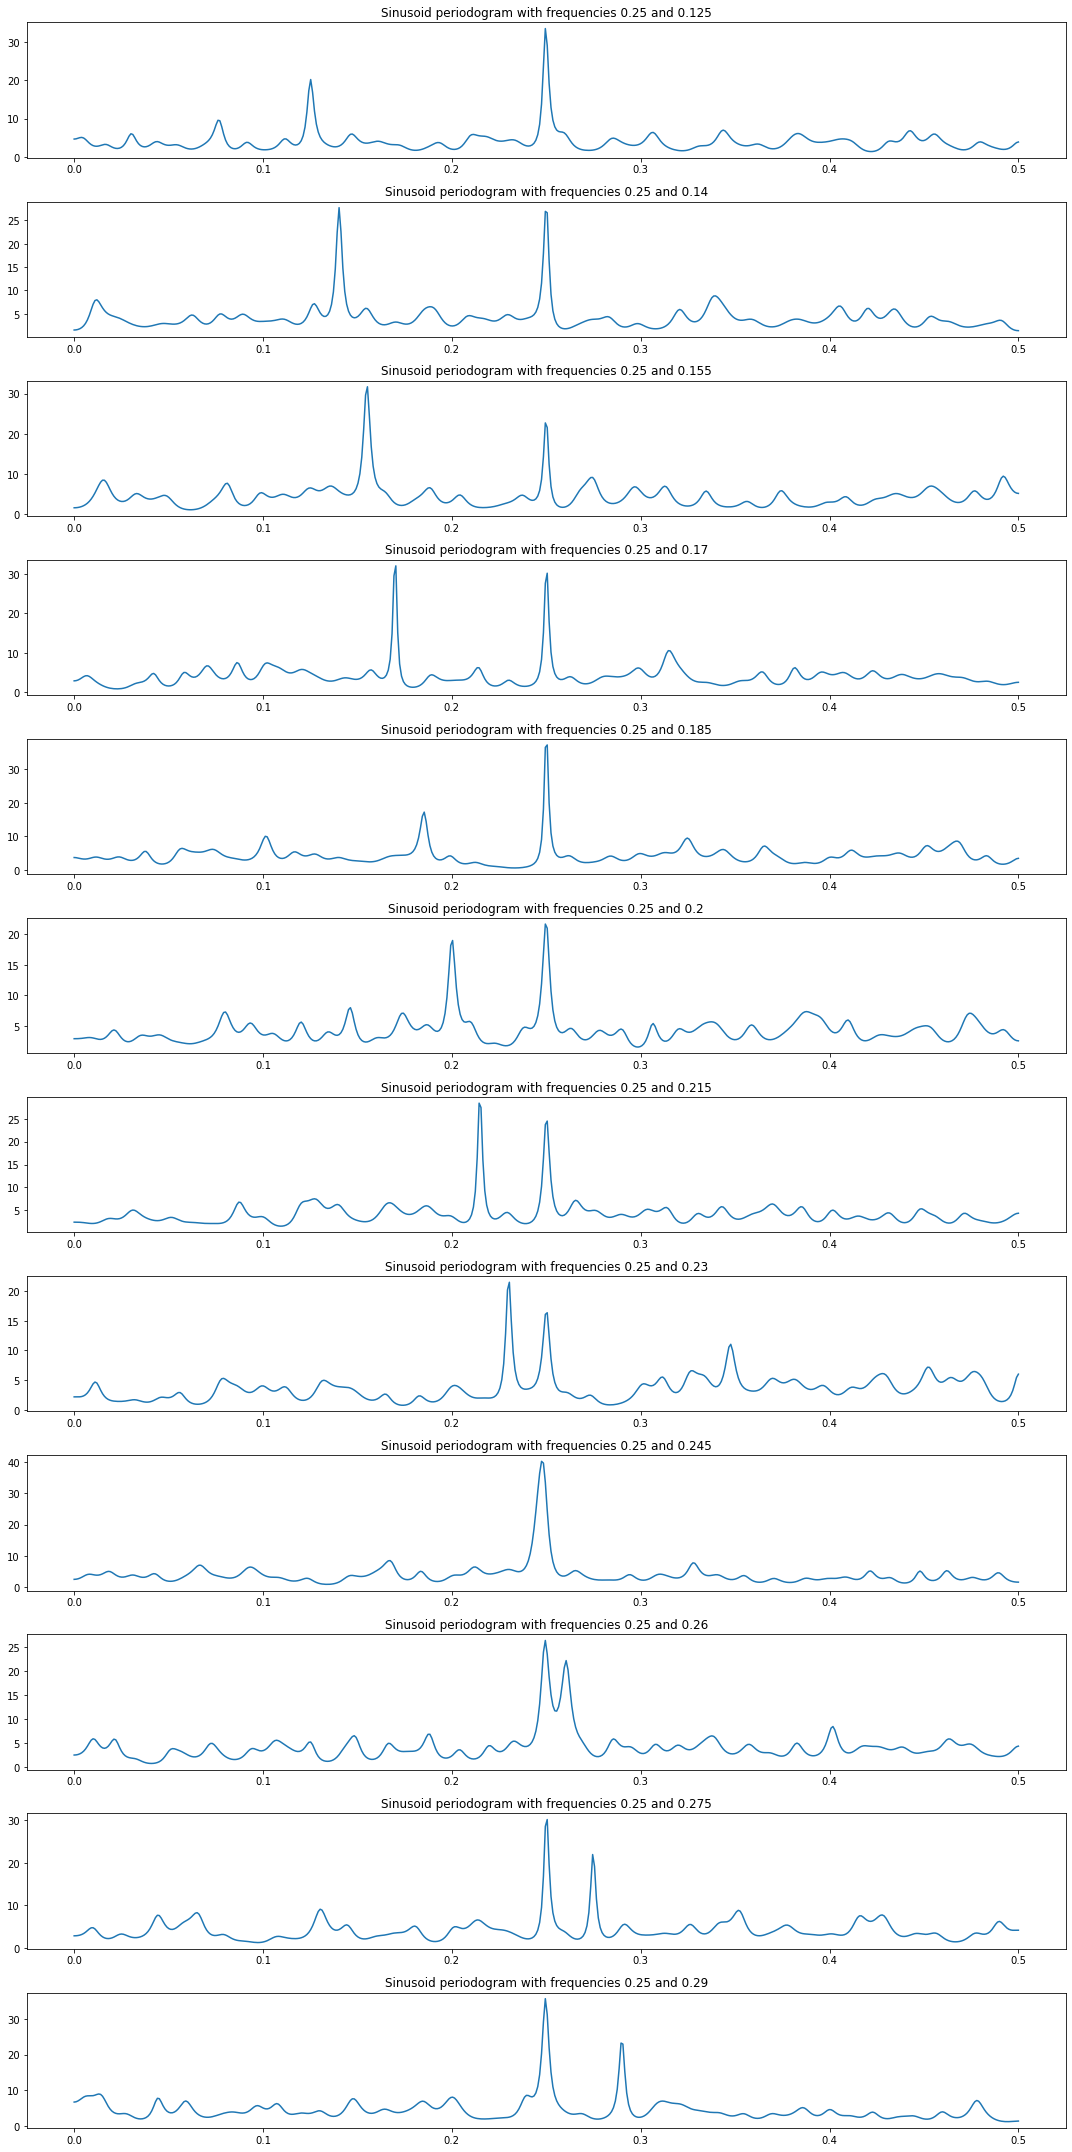

In [46]:
plt.subplots(12, 1, figsize=(15, 30))
for i in range(12):
    sinusoid = sinusoid_synthesis(500, 2, [125, (62.5 + i*7.5)], [1, 1], [0, 0], 2)
    
    plt.subplot(12, 1, i+1)
    plt.title(f'Sinusoid periodogram with frequencies 0.25 and {(62.5 + i*7.5)/500}')
    freq_cap = np.linspace(0, 0.5, len(sinusoid))
    cap = capon(sinusoid, 100, freq_cap)
    plt.plot(freq_cap, cap)
    
    
plt.tight_layout()
plt.show()

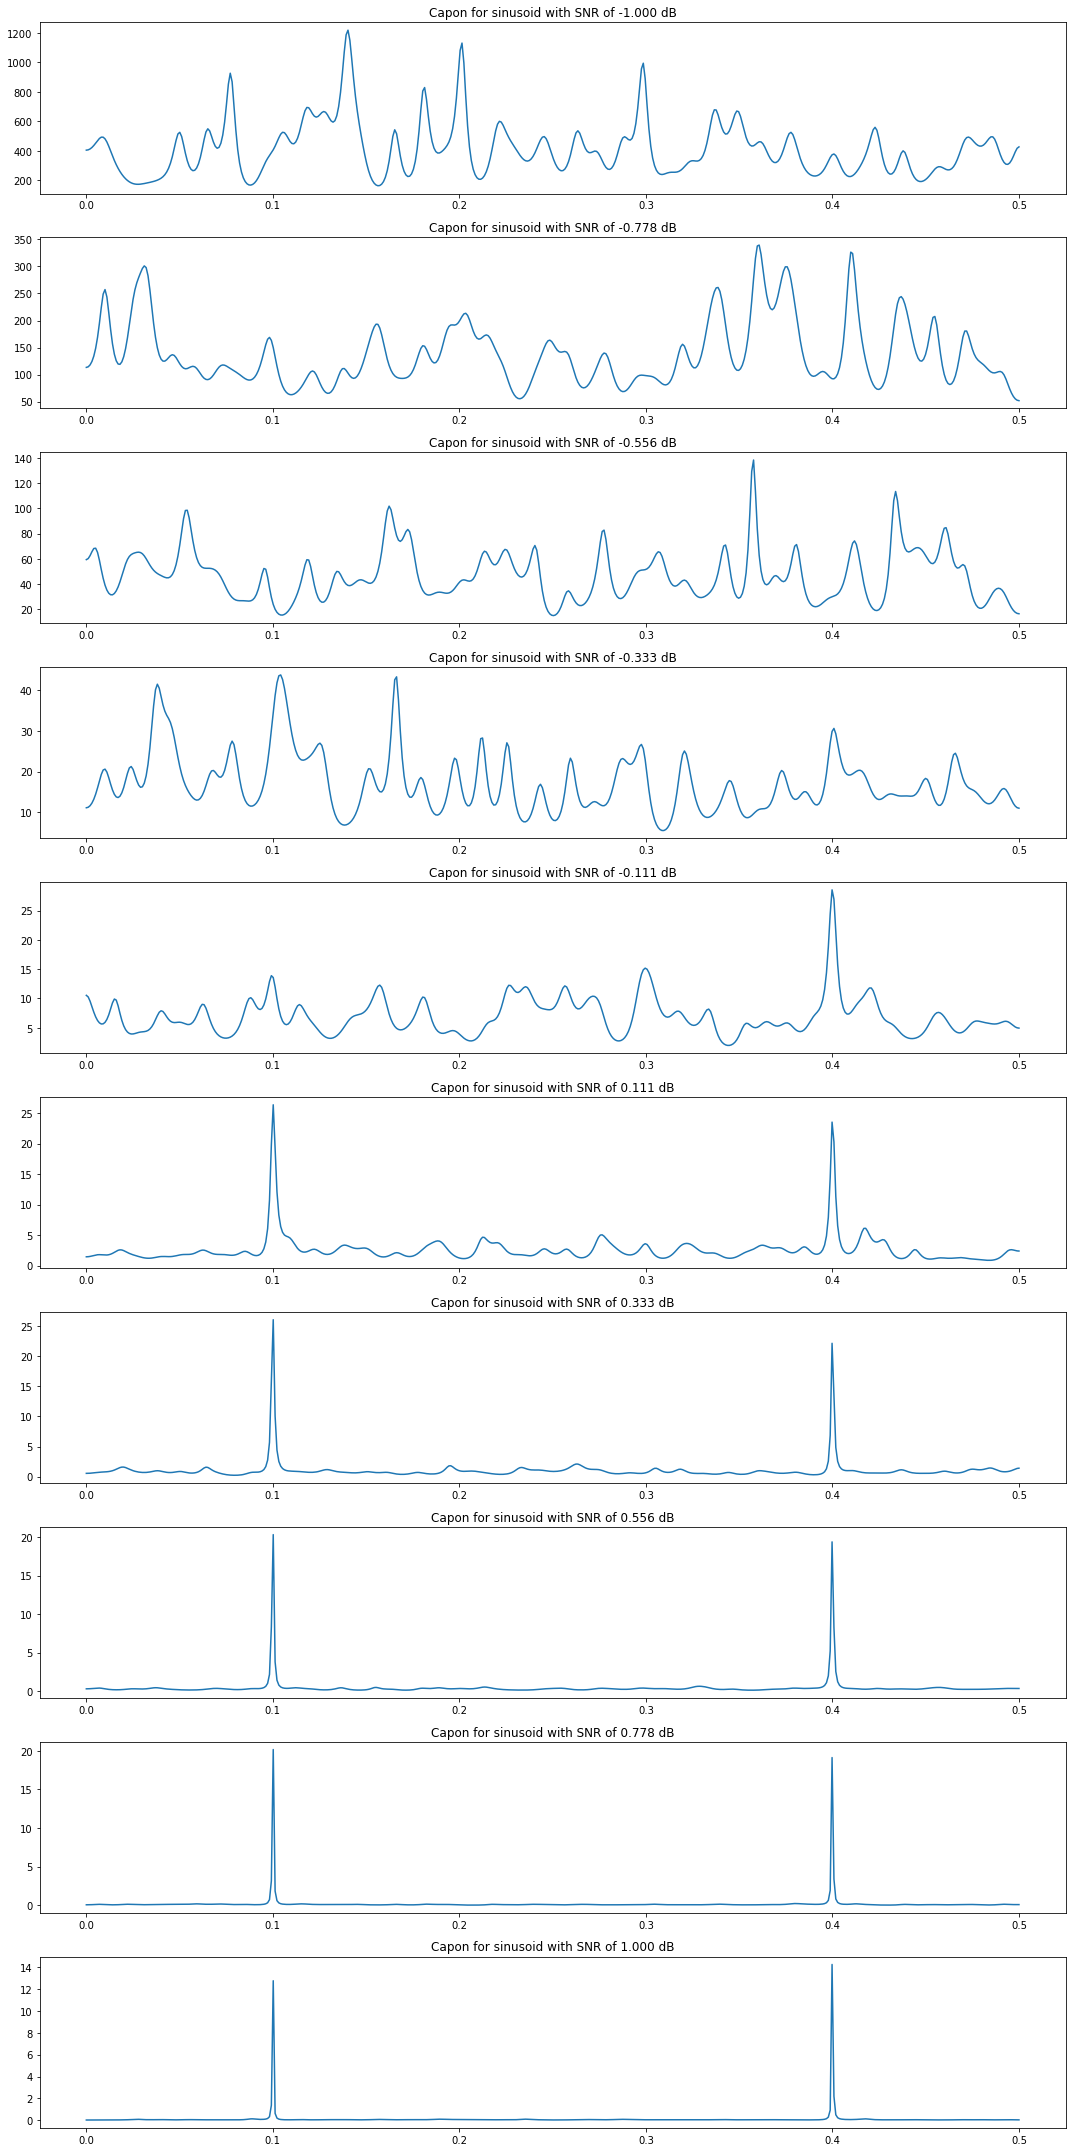

In [47]:
plt.subplots(10, 1, figsize=(15, 30))
aux = np.linspace(-1, 1, 10)
noise = 2/(10**aux)

for i in range(10):
    sinusoid = sinusoid_synthesis(500, 2, [50, 200], [1, 1], [0, 0], noise[i])
    plt.subplot(10, 1, i+1)
    plt.title(f'Capon for sinusoid with SNR of {np.log10(2/noise[i]):.3f} dB')
    freq_cap = np.linspace(0, 0.5, len(sinusoid))
    cap = capon(sinusoid, 100, freq_cap)
    plt.plot(freq_cap, cap)
    
    
plt.tight_layout()
plt.show()

## 3.1
### 1

To make an ARMA(1, 1) generator the following formula was used:
$$X_t = \phi X_{t-1} + \theta \epsilon_{t-1} + \epsilon_{t}$$

In [48]:
def ARMA_11 (n, sigma2, coef_ar, coef_ma):
    noise = np.random.normal(0, sigma2, n+1)
    arma = np.zeros(n+1)
    arma[0] = noise[0]
    for i in range(1, n+1):
        arma[i] = noise[i] + coef_ar*arma[i-1] + coef_ma*noise[i-1]
    return arma[1:], noise[1:]

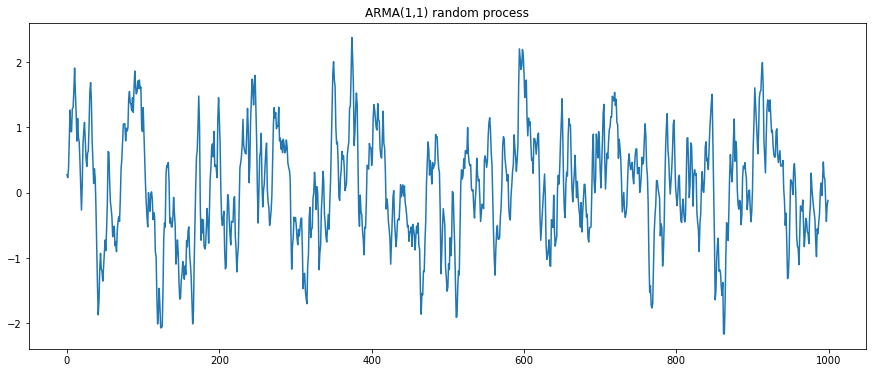

In [49]:
arma_noise = 0.3
coef_ar = 0.9
coef_ma = 0.4
plt.figure(figsize=(15,6))
arma, noise = ARMA_11(1000, arma_noise, coef_ar, coef_ma)
plt.plot(arma)
plt.title('ARMA(1,1) random process')
plt.show()

### 2
The formula used to calculate the estimated PSD followed the close form PSD for an ARMA process:

$$S(f) = \sigma^2 \left|\frac{1+\theta e^{-2\pi i f}}{1-\phi e^{-2\pi i f}}\right|^2$$

In [50]:
def ARMA_PSD(freq, coef_ar, coef_ma, sigma2):
    return sigma2 * abs((1+coef_ma*np.exp(-1j*2*np.pi*freq))/(1-coef_ar*np.exp(-1j*2*np.pi*freq)))**2

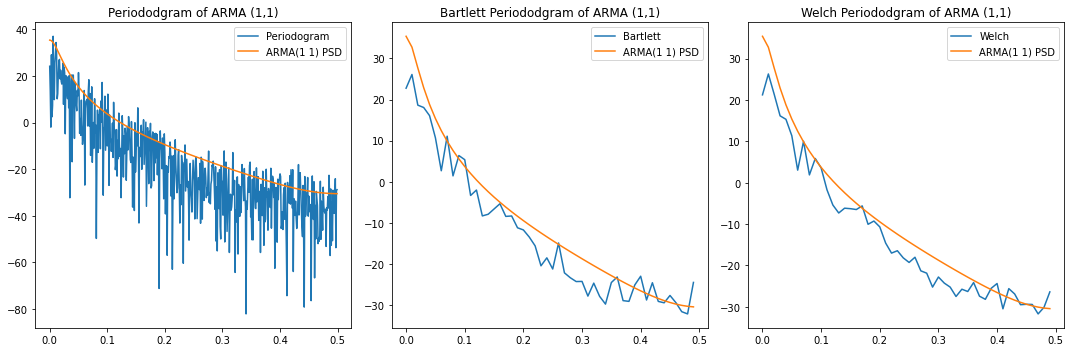

In [51]:
plt.subplots(1, 3, figsize=(15, 5))
freq_psd_arma = np.linspace(0, 0.5, 1000)
psd_per_arma = ARMA_PSD(freq_psd_arma, coef_ar, coef_ma, arma_noise)

plt.subplot(131)
freq_per_arma, per_arma = periodogram(arma)

freq_per_arma = freq_per_arma[:int(len(per_arma)/2)]
per_arma = per_arma[:int(len(per_arma)/2)]

psd_per_arma = ARMA_PSD(freq_per_arma, coef_ar, coef_ma, arma_noise)

plt.plot(freq_per_arma, 20*np.log10(per_arma), label='Periodogram')
plt.plot(freq_per_arma, 20*np.log10(psd_per_arma), label='ARMA(1 1) PSD')
plt.title('Periododgram of ARMA (1,1)')
plt.legend()

plt.subplot(132)
freq_bar_arma, bar_arma = periodogram(arma, method='bartlett', window_length=100)

freq_bar_arma = freq_bar_arma[:int(len(bar_arma)/2)]
bar_arma = bar_arma[:int(len(bar_arma)/2)]

psd_bar_arma = ARMA_PSD(freq_bar_arma, coef_ar, coef_ma, arma_noise)

plt.plot(freq_bar_arma, 20*np.log10(bar_arma), label='Bartlett')
plt.plot(freq_bar_arma, 20*np.log10(psd_bar_arma), label='ARMA(1 1) PSD')
plt.title('Bartlett Periododgram of ARMA (1,1)')
plt.legend()

plt.subplot(133)
freq_wel_arma, wel_arma = periodogram(arma, method='welch', window_length=100)

freq_wel_arma = freq_wel_arma[:int(len(wel_arma)/2)]
wel_arma = wel_arma[:int(len(wel_arma)/2)]

psd_wel_arma = ARMA_PSD(freq_wel_arma, coef_ar, coef_ma, arma_noise)

plt.plot(freq_wel_arma, 20*np.log10(wel_arma), label='Welch')
plt.plot(freq_wel_arma, 20*np.log10(psd_wel_arma), label='ARMA(1 1) PSD')
plt.title('Welch Periododgram of ARMA (1,1)')
plt.legend()

plt.tight_layout()
plt.show()

### 3

All estimators remain with their previous variance and bias relative performances. 

In [52]:
variance = np.array([np.var(per_arma), np.var(bar_arma), np.var(wel_arma)])
label=['normal', 'bartlett', 'welch']
mse = np.array([])
mse = np.append(mse, mean_squared_error(per_arma, psd_per_arma))
mse = np.append(mse, mean_squared_error(bar_arma, psd_bar_arma))
mse = np.append(mse, mean_squared_error(wel_arma, psd_wel_arma))
bias = np.sqrt(abs(mse-variance))

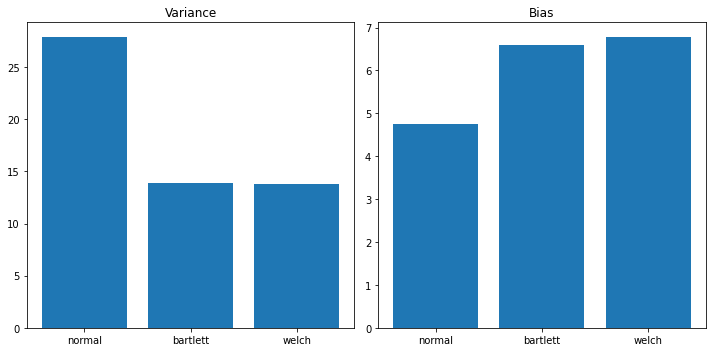

In [53]:
plt.subplots(1, 2, figsize=(10,5))

plt.subplot(121)
plt.bar(label, variance)
plt.title('Variance')

plt.subplot(122)
plt.bar(label, bias)
plt.title('Bias')

plt.tight_layout()
plt.show()

## 3.2
### 4

In [54]:
def arma_estimate(y, p, q):
    # Main function: I will assume the values for this lab on commentary
        # Parameters:
            # y: arma time series: array size 1000
            # p: AR order: 1
            # q: MA order: 1
        # Returns:
            # coef: AR coefficient: array size 1
            # theta: ??: array size 2
            # sigma2: variance estimator: number

    _, coef = TS1_Linear_Prediction(y, display=False)
    e = arma_estimate_step1 (y, p, -coef)
    theta, sigma2 = arma_estimate_step2(y, e, p, q)
    return -coef[1:], -theta[1:][0], sigma2

def arma_estimate_step1 (y, K, coef):
    # Does step 1 in accordance to equation 3.7.17 in page 113
        # Parameters:
            # y: arma time series: array size 1000
            # K: AR order: 1
            # coef: estimated AR coefficient: array size 1
        # Returns:
            # e: estimated noise vector: array size 1000
    e = np.zeros(len(y))
    for i in range(K, len(y)):
        e[i] = y[i] + step1_sum(coef, y, i)
    return e

def step1_sum(coef, y, t):
    # Does the sum of step 1 in accordance to equation 3.7.17 in page 113
        # Parameters:
            # y: arma time series: array size 1000
            # coef: estimated AR coefficient: array size 1
            # t: iteration from step 1: number
        # Returns: 
            # summ: value in sum on equation 3.7.17 on page 113 for each t
    summ = 0
    for i in range(1, len(coef)):
        summ += coef[i]*y[t-i]
    return summ

def arma_estimate_step2(y, e, m, n):
    # Does step 2 on page 113
        # Parameters
            # m: AR order: 1
            # n: MA order: 1
            # e: noise estimate obtained from step 1: array size 1000
            # y: ARMA time series: array size 1000
        # Returns:
            # theta: ??: array size 2
            # sigma2: estimated noise variance: number
    Z, z = Z_z_estimate(y, e, m+n, m, n)
    theta = ma_estimate(Z, z)
    e2 = e_new_estimate(z, Z, theta)
    sigma2 = sigma_estimate(len(y), m+n, e2)
    return theta, sigma2

def ma_estimate(Z, z):
    # Estimates theta as in equation 3.7.15 on page 112
    # Don't need conjugate because everything is real
        # Parameters:
            # Z: Matrix 3.7.12 on page 112: matrix size 998x2
            # z: matrix 3.7.13 on page 112: matrix size 998x1
        # Returns:
            # theta: ??: array size 2
    
    return -np.linalg.inv(Z.T@Z)@(Z.T@z)

def Z_z_estimate(y, e, L, m, n):
    # Finds Z and z as in page 3.7.12
        # Parameters:
            # m: AR order: 1
            # n: MA order: 1
            # e: noise estimate obtained from step 1: array size 1000
            # y: ARMA time series: array size 1000
            # L: ??: 2 (m+n)
        # Returns
            # Z: Matrix 3.7.12 on page 112: matrix size 998x2
            # z: matrix 3.7.13 on page 112: matrix size 998x1
    z = y[L:].copy()
    z = z.reshape(len(z), 1)
    j = L-1
    N = len(y)
    Z = np.array([])
    while j <= N-2:
        # Finds the fist half of Z
        i = 0
        while i >= 1 - n:
            Z = np.append(Z, y[j+i])
            i -= 1
        # Finds the second half of Z
        i = 0
        while i >= 1 - m:
            Z = np.append(Z, -e[j+i])
            i -= 1
        j += 1
    Z = Z.reshape(N-L, L)
    return Z, z

def e_new_estimate(z, Z, theta):
    # Finds the new e as in equation 3.7.11: matrix size 998x1
        # Parameters
            # Z: Matrix 3.7.12 on page 112: matrix size 998x2
            # z: matrix 3.7.13 on page 112: matrix size 998x1
            # theta: ??: array size 2
        # Returns 
            # e~: ??: array size 998x1
    return Z@theta + z

def sigma_estimate(N, L, e2):
    # Finds noise variance:
        # Parameters:
            # e~: ??: array size 998x1
            # L: ??: 2 (m+n)
            # N: y length: 1000
    return (e2.T@e2)[0][0]/(N-L)

In [55]:
AR, MA, arma_sigma = arma_estimate(arma, 1, 1)

In [56]:
print(f'The AR coefficients obtained were: {AR}')
print(f'The MA coefficients obtained were: {MA.T} ')
print(f'The noise variance obtained was: {arma_sigma}')

The AR coefficients obtained were: [0.92322599]
The MA coefficients obtained were: [0.38936803] 
The noise variance obtained was: 0.08911759582331469


Its not great, but after reading Stoica it said that great method a doesn't exist. So its better than nothing. I used the spectrum function in order to evaluate the quality of my estimation.

In [57]:
import spectrum

In [58]:
spec_ar, spec_ma, spec_var = spectrum.arma_estimate(arma, 1, 1, 2)
print(f'Spectrums AR prediction was {abs(spec_ar[0])}')
print(f'Spectrums MA prediction was {abs(spec_ma[0])}')

Spectrums AR prediction was 0.8682129778636728
Spectrums MA prediction was 0.3854367125944805


Both methods had similar values, I will use spectrum's code as a reference from now onwards to be sure of my code's accuracy.

### 5

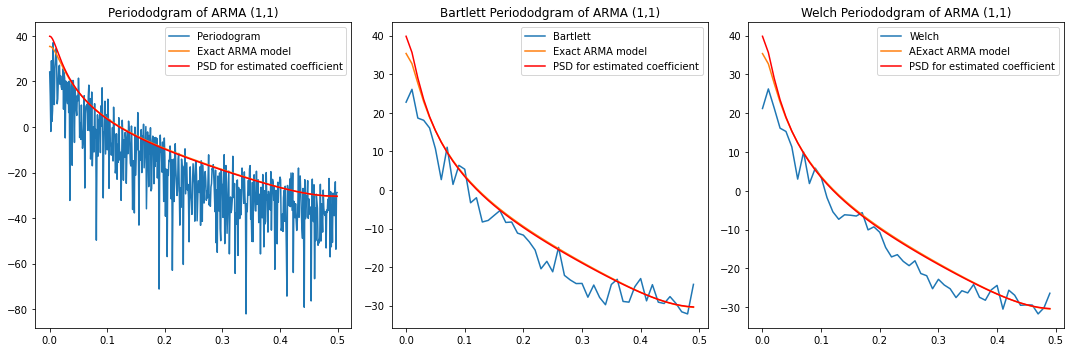

In [113]:
plt.subplots(1, 3, figsize=(15, 5))
#freq_psd_arma = np.linspace(-0.5, 0.5, 1000)
psd_per_arma = ARMA_PSD(freq_psd_arma, coef_ar, coef_ma, arma_noise)

plt.subplot(131)
freq_per_arma, per_arma = periodogram(arma)

freq_per_arma = freq_per_arma[:int(len(per_arma)/2)]
per_arma = per_arma[:int(len(per_arma)/2)]

psd_per_arma = ARMA_PSD(freq_per_arma, coef_ar, coef_ma, arma_noise)
est_per_arma = ARMA_PSD(freq_per_arma, AR[0], MA[0], arma_noise)

plt.plot(freq_per_arma, 20*np.log10(per_arma), label='Periodogram')
plt.plot(freq_per_arma, 20*np.log10(psd_per_arma), label='Exact ARMA model')
plt.plot(freq_per_arma, 20*np.log10(est_per_arma), label='PSD for estimated coefficient', color='red')
plt.title('Periododgram of ARMA (1,1)')
plt.legend()

plt.subplot(132)
freq_bar_arma, bar_arma = periodogram(arma, method='bartlett', window_length=100)

freq_bar_arma = freq_bar_arma[:int(len(bar_arma)/2)]
bar_arma = bar_arma[:int(len(bar_arma)/2)]

psd_bar_arma = ARMA_PSD(freq_bar_arma, coef_ar, coef_ma, arma_noise)
est_bar_arma = ARMA_PSD(freq_bar_arma, AR[0], MA[0], arma_noise)

plt.plot(freq_bar_arma, 20*np.log10(bar_arma), label='Bartlett')
plt.plot(freq_bar_arma, 20*np.log10(psd_bar_arma), label='Exact ARMA model')
plt.plot(freq_bar_arma, 20*np.log10(est_bar_arma), label='PSD for estimated coefficient', color='red')
plt.title('Bartlett Periododgram of ARMA (1,1)')
plt.legend()

plt.subplot(133)
freq_wel_arma, wel_arma = periodogram(arma, method='welch', window_length=100)

freq_wel_arma = freq_wel_arma[:int(len(wel_arma)/2)]
wel_arma = wel_arma[:int(len(wel_arma)/2)]

psd_wel_arma = ARMA_PSD(freq_wel_arma, coef_ar, coef_ma, arma_noise)
est_wel_arma = ARMA_PSD(freq_wel_arma, AR[0], MA[0], arma_noise)

plt.plot(freq_wel_arma, 20*np.log10(wel_arma), label='Welch')
plt.plot(freq_wel_arma, 20*np.log10(psd_wel_arma), label='AExact ARMA model')
plt.plot(freq_wel_arma, 20*np.log10(est_wel_arma), label='PSD for estimated coefficient', color='red')
plt.title('Welch Periododgram of ARMA (1,1)')
plt.legend()

plt.tight_layout()
plt.show()

### 6

From the code below you can tell that the nasal sound behaves like an ARMA(1 1) process, since the prediction and the periodogram are very similar. I plotted the estimated coefficients from the "Spectrum" package and my own. Both returned very similar results.

In [60]:
# CODE FROM TSIA201
data_path = os.getcwd()
filename = 'an_in_on.wav'
sound = os.path.join(data_path, filename) 

In [61]:
# CODE FROM TSIA201
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=28270, comptype='NONE', compname='not compressed')


In [62]:
# CODE FROM TSIA201
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)
x = x/32768

In [63]:
# CODE FROM TSIA201
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

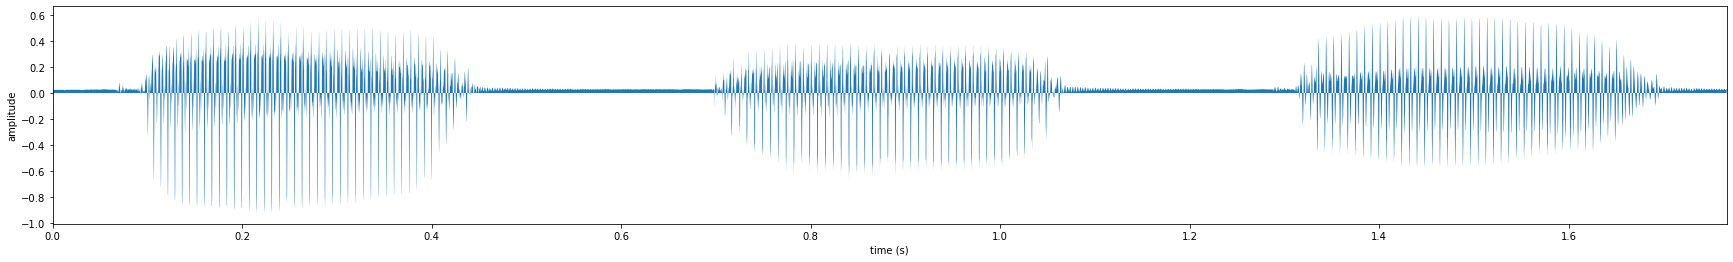

In [64]:
plot_sound(x, times)

In [65]:
ipd.Audio(x, rate=16000)

In [66]:
np.argmax(times>0.1)

1601

In [67]:
np.argmin(times<0.4)

6400

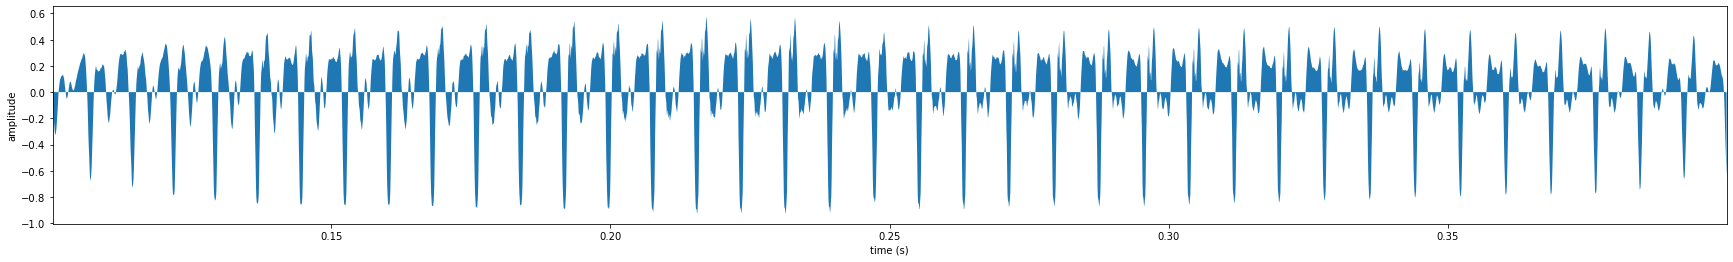

In [68]:
vowel_an = x[1601:6400]
time_an = times[1601:6400]
plot_sound(vowel_an, time_an)

In [69]:
ipd.Audio(vowel_an, rate=16000)

In [70]:
spec_ar, spec_ma, noise_an = spectrum.arma_estimate(vowel_an, 1, 1, 2)
ar_an = abs(spec_ar[0])
ma_an = abs(spec_ma[0])

In [71]:
ar_est_mine, ma_est_mine, arma_sigma = arma_estimate(vowel_an, 1, 1)
ar_est_mine = ar_est_mine[0]
ma_est_mine = ma_est_mine[0]

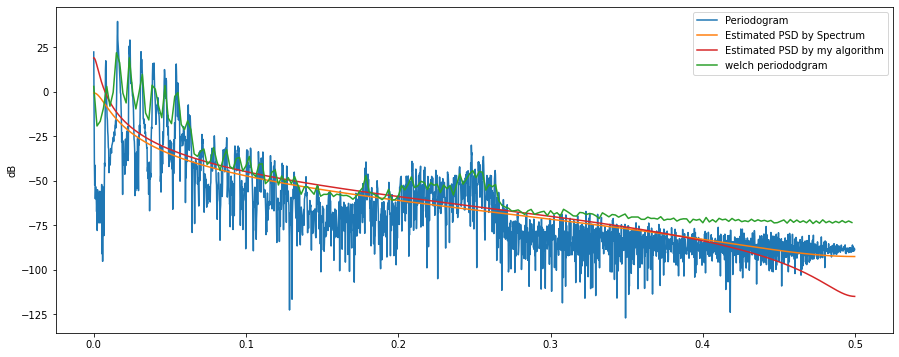

In [112]:
plt.figure(figsize=(15,6))

freq_per_an, per_an = periodogram(vowel_an)
freq_per_an = freq_per_an[:int(len(per_an)/2)]
per_an = per_an[:int(len(per_an)/2)]
plt.plot(freq_per_an, 20*np.log10(per_an), label='Periodogram')

est_per_an = ARMA_PSD(freq_per_an, ar_an, ma_an, noise_an)

est_per_an_mine = ARMA_PSD(freq_per_an, ar_est_mine, ma_est_mine, noise_an)

plt.plot(freq_per_an, 20*np.log10(est_per_an), label='Estimated PSD by Spectrum')

plt.plot(freq_per_an, 20*np.log10(est_per_an_mine), label='Estimated PSD by my algorithm', color='C3')

aa, bb = periodogram(vowel_an[:4700], method='welch', window_length=470)
aa=aa[:int(len(aa)/2)]
bb=bb[:int(len(bb)/2)]

plt.plot(aa, 20*np.log10(bb), label='welch periododgram')

plt.ylabel('dB')
plt.legend()
plt.show()